In [1]:
"""
Simple google colab example of running two ma cross strategies at the same time 
on two different sets of assets
"""

!git clone https://github.com/ntorm1/FastTest.git
!cd /content/FastTest && git pull
!cd /content/FastTest && cmake -B build
!cd /content/FastTest/build && make -j
!cd /content/FastTest/wrapper/tests && python test.py

fatal: destination path 'FastTest' already exists and is not an empty directory.
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8 (delta 6), reused 8 (delta 6), pack-reused 0
Unpacking objects: 100% (8/8), 1.08 KiB | 277.00 KiB/s, done.
From https://github.com/ntorm1/FastTest
   c0403df..9d3d1a7  main       -> origin/main
Updating c0403df..9d3d1a7
Fast-forward
 wrapper/FastTest.py                         |   6 ++++--
 wrapper/__pycache__/FastTest.cpython-39.pyc | Bin 16432 -> 16454 bytes
 wrapper/scripts/Agis.py                     |   4 ++--
 3 files changed, 6 insertions(+), 4 deletions(-)
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older vers

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import sys
import math

sys.path.append("/content/FastTest/wrapper")
from Exchange import Exchange, Asset
from Broker import Broker
from Strategy import Strategy
from FastTest import FastTest
import matplotlib.pyplot as plt
import yfinance as yf

In [27]:
fast_ma_tech = 20
fast_ma_banks = 50
slow_ma_tech = 50
slow_ma_banks = 200

yfinance_tickers = {
    'C' : 'Citigroup',
    'GS' : "Goldman",
    "WFC" : "Wells_Fargo",

    "AAPL" : "Apple",
    "IBM" : "IBM",
    "AMZN" : "AMZN"

}
tickers = list(yfinance_tickers.keys())
start_date = "2005-01-01"

data = yf.download(tickers, start = start_date, group_by = 'ticker')
data.columns = [' '.join(col).strip() for col in data.columns.values]
data.reset_index(inplace = True)
data = data.rename(columns = {"Date" : "DATE"})
data["DATE"] = data["DATE"].apply(lambda x:x.tz_localize(None))

dfs_tech = {}
dfs_banks = {}

for ticker in ["C","GS","WFC"]:
  ticker_cols = [col for col in data.columns if ticker == col.split(" ")[0]]
  df_mid = data[ticker_cols]
  df_mid.index = data["DATE"]
  df_mid["slow_ma"] = df_mid[ticker + " Adj Close"].rolling(window = slow_ma_banks).mean()
  df_mid["fast_ma"] = df_mid[ticker + " Adj Close"].rolling(window = fast_ma_banks).mean()
  df_mid = df_mid.rename(columns = {ticker + " Adj Close" : "CLOSE"})
  dfs_banks[ticker] = df_mid

for ticker in ["AAPL","IBM","AMZN"]:
  ticker_cols = [col for col in data.columns if ticker in col]
  df_mid = data[ticker_cols]
  df_mid.index = data["DATE"]
  df_mid["slow_ma"] = df_mid[ticker + " Adj Close"].rolling(window = slow_ma_tech).mean()
  df_mid["fast_ma"] = df_mid[ticker + " Adj Close"].rolling(window = fast_ma_tech).mean()
  df_mid = df_mid.rename(columns = {ticker + " Adj Close" : "CLOSE"})
  dfs_tech[ticker] = df_mid

df_mid.tail()

[*********************100%***********************]  6 of 6 completed


<ipython-input-27-0073c930c631>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mid["slow_ma"] = df_mid[ticker + " Adj Close"].rolling(window = slow_ma_banks).mean()
<ipython-input-27-0073c930c631>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mid["fast_ma"] = df_mid[ticker + " Adj Close"].rolling(window = fast_ma_banks).mean()
<ipython-input-27-0073c930c631>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,AMZN Open,AMZN High,AMZN Low,AMZN Close,CLOSE,AMZN Volume,slow_ma,fast_ma
DATE,,,,,,,,
2023-01-23,97.559998,97.779999,95.860001,97.519997,97.519997,76501100,91.1144,89.3955
2023-01-24,96.930000,98.089996,96.000000,96.320000,96.320000,66929500,91.3180,90.0220
2023-01-25,92.559998,97.239998,91.519997,97.180000,97.180000,94261600,91.3290,90.6185
2023-01-26,98.239998,99.489998,96.919998,99.220001,99.220001,68523600,91.2976,91.4275
2023-01-27,99.529999,103.489998,99.529999,102.239998,102.239998,87678100,91.3726,92.4485


In [28]:
class MA_Cross_Strategy(Strategy):
    def __init__(self, broker: Broker, exchange: Exchange, ft: FastTest, slow_ma : int, fast_ma : int) -> None:
        super().__init__(broker, exchange)
        self.ft = ft
        self.candle_count = 0
        self.slow_ma = slow_ma
        self.fast_ma = fast_ma
        self.asset_count = 3
        
    def build(self):
        self.asset_names = self.exchange.id_map.values()
        self.position_size = .9 * (100000/self.asset_count)
        
    def next(self):
        #pull in the data needed to calcuate moving average crossovers
        slow_ma_dict = {asset_name : self.exchange.get(asset_name, "slow_ma") for asset_name in self.asset_names}
        fast_ma_dict = {asset_name : self.exchange.get(asset_name, "fast_ma") for asset_name in self.asset_names}

        for key in slow_ma_dict:
            #check to see if the asset is currently tradeable
            if not math.isnan(slow_ma_dict[key]):
                #check to see if a position with the same asset currently exists
                if not self.broker.position_exists(key,exchange_name = self.exchange.exchange_name):
                    
                    market_price = self.exchange.get_market_price(key)
                    units = self.position_size / market_price
                    
                    if fast_ma_dict[key] < slow_ma_dict[key]:
                        units *= -1
                        
                    self.broker.place_market_order(key, units,
                                                   exchange_name = self.exchange.exchange_name,
                                                   account_name = self.exchange.exchange_name)
                    
                else:
                    #get the open position with the same asset name
                    position = self.broker.get_position(key,
                                                        exchange_name = self.exchange.exchange_name,
                                                        account_name = self.exchange.exchange_name)
                    fast = fast_ma_dict[key]
                    slow = slow_ma_dict[key]
                    
                    #position is in right direction
                    if fast < slow and position.units < 0:
                        continue
                    elif fast > slow and position.units > 0:
                        continue                    
                    #close existing position
                    else:
                        units = -1 * position.units
                        self.broker.place_market_order(key, units,
                                                       exchange_name = self.exchange.exchange_name,
                                                       account_name = self.exchange.exchange_name)

In [33]:
"""
For illustration purposes split the assets into two exchanges. This allows us to easily run two strategies at the same time.
In principle the strategies can differ so here we use two ma cross strategies with different parameters. 
Notice the use of two different accounts so we can track the performance of each indivual strategy
"""

ft = FastTest(logging=False, debug=False)
tech_exchange = Exchange(exchange_name="tech")
bank_exchange = Exchange(exchange_name="bank")
ft.register_exchange(tech_exchange)
ft.register_exchange(bank_exchange)

"""
The open price is not adjusted so we have to use the adjusted close for both the open and the close price. This means 
essentially we are only trading at the close of each day. An order placed on close on 2000-01-01 would be executed at close of 2000-01-02
"""
for ticker in list(dfs_tech.keys()):
  new_asset = ft.register_asset(ticker, exchange_name = "tech")
  new_asset.set_format("%d-%d-%d", 4, 4)
  new_asset.load_from_df(dfs_tech[ticker], nano = True)
  new_asset.set_warmup(slow_ma_tech)

for ticker in list(dfs_banks.keys()):
  new_asset = ft.register_asset(ticker, exchange_name = "bank")
  new_asset.set_format("%d-%d-%d", 4, 4)
  new_asset.load_from_df(dfs_banks[ticker], nano = True)
  new_asset.set_warmup(slow_ma_banks)

"""
Create broker class and register two seperate classes to it
"""
broker = Broker(tech_exchange, logging=False)
broker.register_exchange(bank_exchange)
ft.register_broker(broker)
ft.add_account("tech",100000)
ft.add_account("bank",100000)

"""
Create two ma cross strategies with different params and register them to the fasttest
"""
ma_cross_strategy_tech = MA_Cross_Strategy(broker, tech_exchange, ft, slow_ma = slow_ma_tech, fast_ma = fast_ma_tech) 
ma_cross_strategy_bank = MA_Cross_Strategy(broker, bank_exchange, ft, slow_ma = slow_ma_banks, fast_ma = fast_ma_banks) 

ft.add_strategy(ma_cross_strategy_tech)
ft.add_strategy(ma_cross_strategy_bank)

ft.build()

ft.run()

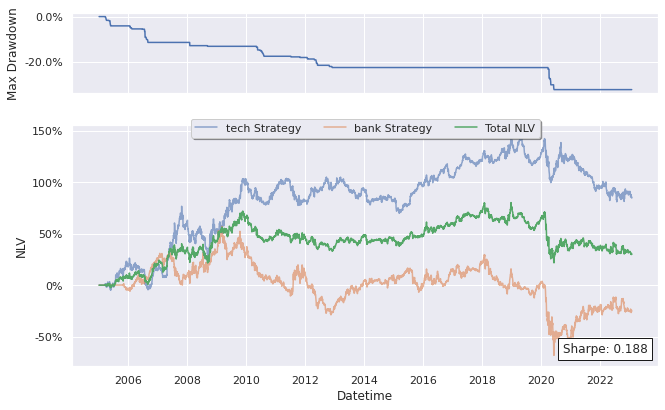

In [34]:
ft.plot()

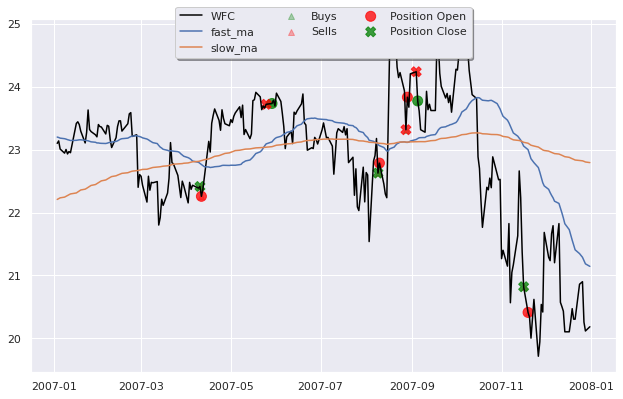

In [35]:
ft.plot_asset("WFC", overlays=["fast_ma","slow_ma"], _from = "2007-01-01", _to = "2008-01-01")